In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace, mass
from skfem.helpers import grad, dot, laplacian

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg


In [3]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True)
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

def graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p):

    plt.figure(figsize=(8,6))
    scatter_ux = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_x, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_ux, label='$\\Delta u_x$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_x$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de u_y
    plt.figure(figsize=(8,6))
    scatter_uy = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_y, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_uy, label='$\\Delta u_y$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_y$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de la presión
    plt.figure(figsize=(8,6))
    scatter_p = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_p, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_p, label='$\\Delta p$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta p$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

## Test 1

In [4]:
# Definir dominio y mallado
nx, ny = 20, 20
mesh = MeshTri.init_tensor(
    np.linspace(-1.0, 1.0, nx + 1), 
    np.linspace(-1.0, 1.0, ny + 1)
)

mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == -1.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == -1.0,
    'top':    lambda x: x[1] == 1.0,
})

In [5]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N = Nu + Np

In [6]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M =  asm(mass_matrix, basis_u)    

# Construcción del ssitema
K = bmat([[A,    B.T],
          [B,    None]], format='csr') 

zeros = sp.csr_matrix((basis_p.N, basis_p.N))  
L = bmat([[M,   None],
          [None, zeros]], format='csr')


In [7]:
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

D_all = np.unique(np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom,
    Nu + np.array([0])
]) )

In [8]:
A_sys, xI, I   = condense(K, D=D_all)
M_sys, xIM, IM = condense(L, D=D_all)

In [9]:
vals, vecs = eigs(A_sys, k=10, M=M_sys, sigma=0.0, which='LM', OPpart='r')

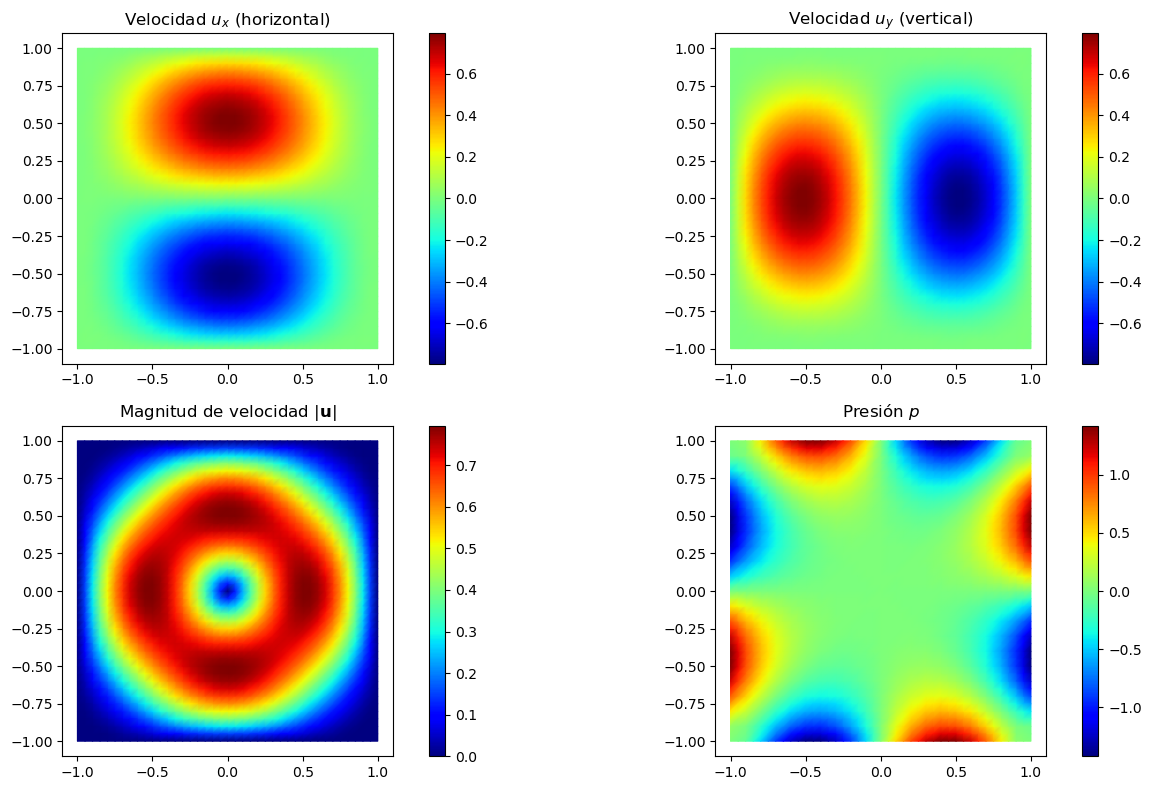

In [10]:
# Filtrar valores propios reales (parte imaginaria exactamente cero)
mask_real = np.isclose(vals.imag, 0)
vals = vals[mask_real].real
vecs = vecs[:, mask_real].real

# Ordenar autovalores
idx = np.argsort(vals)
eigenvalues = vals[idx]
eigenvectors = vecs[:, idx]

# Insertar la solución reducida en el vector global (con ceros en frontera)
u_sol = np.zeros(K.shape[0])

sol_idx = 0
u_sol[I] = eigenvectors[:, sol_idx]  # Primer modo

# Separar componentes de velocidad y presión
u_velocity = u_sol[:Nu]
p_pressure = u_sol[Nu:]
graficar_stokes(u_velocity, p_pressure, mesh, basis_p, basis_u)

In [11]:
vals_test1 = [13.086, 23.031, 32.053, 38.532, 41.759]
vals_extr1 = [13.0860, 23.0308, 32.0443, 38.5353, 41.7588]
tabla_eigen = pd.DataFrame({
    'Test': ['Extrapolado','Referencia [17]', 'SKFEM'],
    'Valor propio 1': [vals_extr1[0], vals_test1[0], eigenvalues[0]],
    'Valor propio 2': [vals_extr1[1], vals_test1[1], eigenvalues[1]],
    'Valor propio 3': [vals_extr1[2], vals_test1[2], eigenvalues[3]],
    'Valor propio 4': [vals_extr1[3], vals_test1[3], eigenvalues[4]],
    'Valor propio 5': [vals_extr1[4], vals_test1[4], eigenvalues[5]],
})
tabla_eigen

,Test,Valor propio 1,Valor propio 2,Valor propio 3,Valor propio 4,Valor propio 5
0,Extrapolado,13.086000,23.03080,32.044300,38.535300,41.758800
1,Referencia [17],13.086000,23.03100,32.053000,38.532000,41.759000
2,SKFEM,13.086781,23.03326,32.061252,38.541785,41.769848


## Test 2

In [15]:
# Definir dominio y mallado
nx, ny = 40, 40
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [13]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N = Nu + Np

In [14]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M =  asm(mass_matrix, basis_u)    

# Construcción del ssitema
K = bmat([[A,    B.T],
          [B,    None]], format='csr') 

zeros = sp.csr_matrix((basis_p.N, basis_p.N))  
L = bmat([[M,   None],
          [None, zeros]], format='csr')


In [15]:
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

D_all = np.unique(np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom,
    Nu + np.array([0])
]) )

In [16]:
A_sys, xI, I   = condense(K, D=D_all)
M_sys, xIM, IM = condense(L, D=D_all)

In [17]:
vals, vecs = eigs(A_sys, k=10, M=M_sys, sigma=0.0, which='LM', OPpart='r')

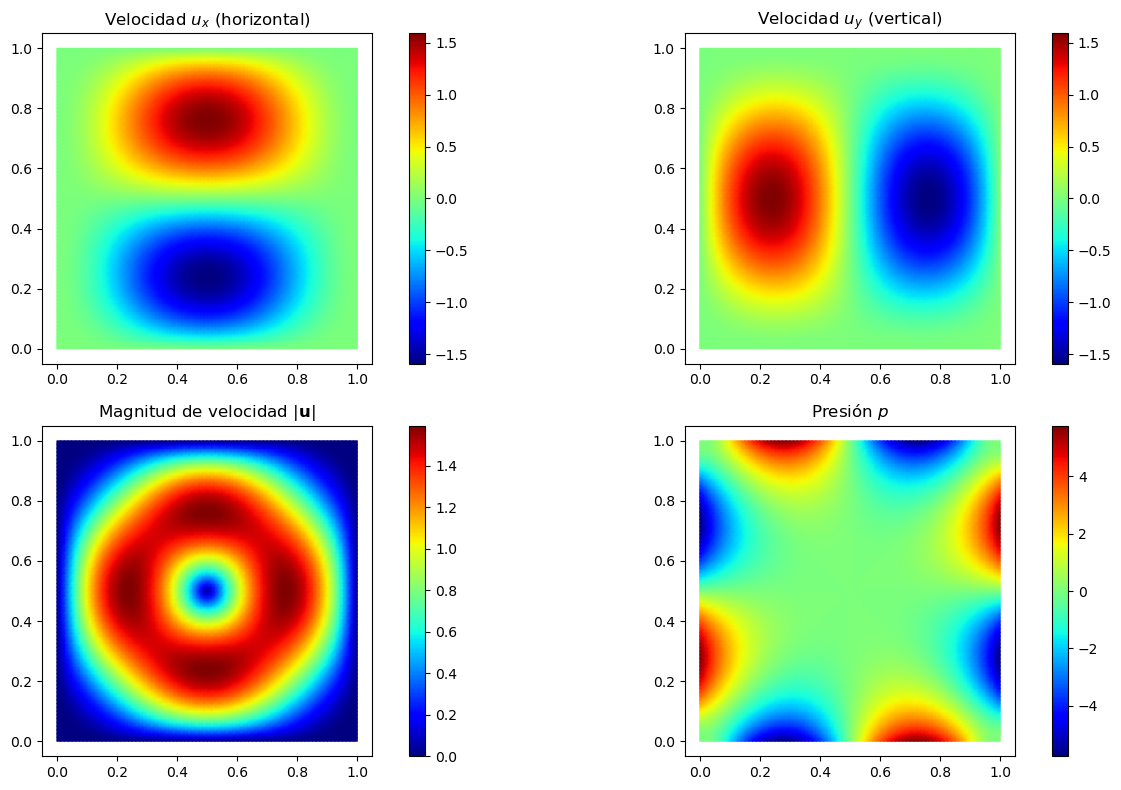

In [18]:
# Filtrar valores propios reales (parte imaginaria exactamente cero)
mask_real = np.isclose(vals.imag, 0)
vals = vals[mask_real].real
vecs = vecs[:, mask_real].real

# Ordenar autovalores
idx = np.argsort(vals)
eigenvalues = vals[idx]
eigenvectors = vecs[:, idx]

# Insertar la solución reducida en el vector global (con ceros en frontera)
u_sol = np.zeros(K.shape[0])

sol_idx = 0
u_sol[I] = eigenvectors[:, sol_idx]  # Primer modo

# Separar componentes de velocidad y presión
u_velocity = u_sol[:Nu]
p_pressure = u_sol[Nu:]
graficar_stokes(u_velocity, p_pressure, mesh, basis_p, basis_u)

In [19]:
vals_extr1 = [52.3450, 92.1257, 128.2132, 154.1232, 167.0241]
vals_extr3 = [52.3444, 92.1249, 128.2070, 154.1236, 167.0293]
tabla_eigen = pd.DataFrame({
    'Test': ['Extrapolado FEM', 'Extrapolado_P3', 'SKFEM'],
    'Valor propio 1': [vals_extr1[0], vals_extr3[0], eigenvalues[0]],
    'Valor propio 2': [vals_extr1[1], vals_extr3[1], eigenvalues[1]],
    'Valor propio 3': [vals_extr1[2], vals_extr3[2], eigenvalues[3]],
    'Valor propio 4': [vals_extr1[3], vals_extr3[3], eigenvalues[4]],
    'Valor propio 5': [vals_extr1[4], vals_extr3[4], eigenvalues[5]],
})
tabla_eigen

,Test,Valor propio 1,Valor propio 2,Valor propio 3,Valor propio 4,Valor propio 5
0,Extrapolado FEM,52.345000,92.125700,128.213200,154.123200,167.02410
1,Extrapolado_P3,52.344400,92.124900,128.207000,154.123600,167.02930
2,SKFEM,52.344848,92.124953,128.211896,154.128139,167.03243


## Test 3

In [20]:
# Definir dominio y mallado
nx, ny = 40, 40
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [21]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N = Nu + Np

In [22]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M =  asm(mass_matrix, basis_u)    

# Construcción del ssitema
K = bmat([[A,    B.T],
          [B,    None]], format='csr') 

zeros = sp.csr_matrix((basis_p.N, basis_p.N))  
L = bmat([[M,   None],
          [None, zeros]], format='csr')


In [24]:
# dofs_left     = basis_u.get_dofs('left').all()
# dofs_right    = basis_u.get_dofs('right').all()
# dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

D_all = np.unique(np.concatenate([
    # dofs_left,
    # dofs_right,
    # dofs_top,
    dofs_bottom,
    Nu + np.array([0])
]) )

In [25]:
A_sys, xI, I   = condense(K, D=D_all)
M_sys, xIM, IM = condense(L, D=D_all)

In [26]:
vals, vecs = eigs(A_sys, k=10, M=M_sys, sigma=0.0, which='LM', OPpart='r')

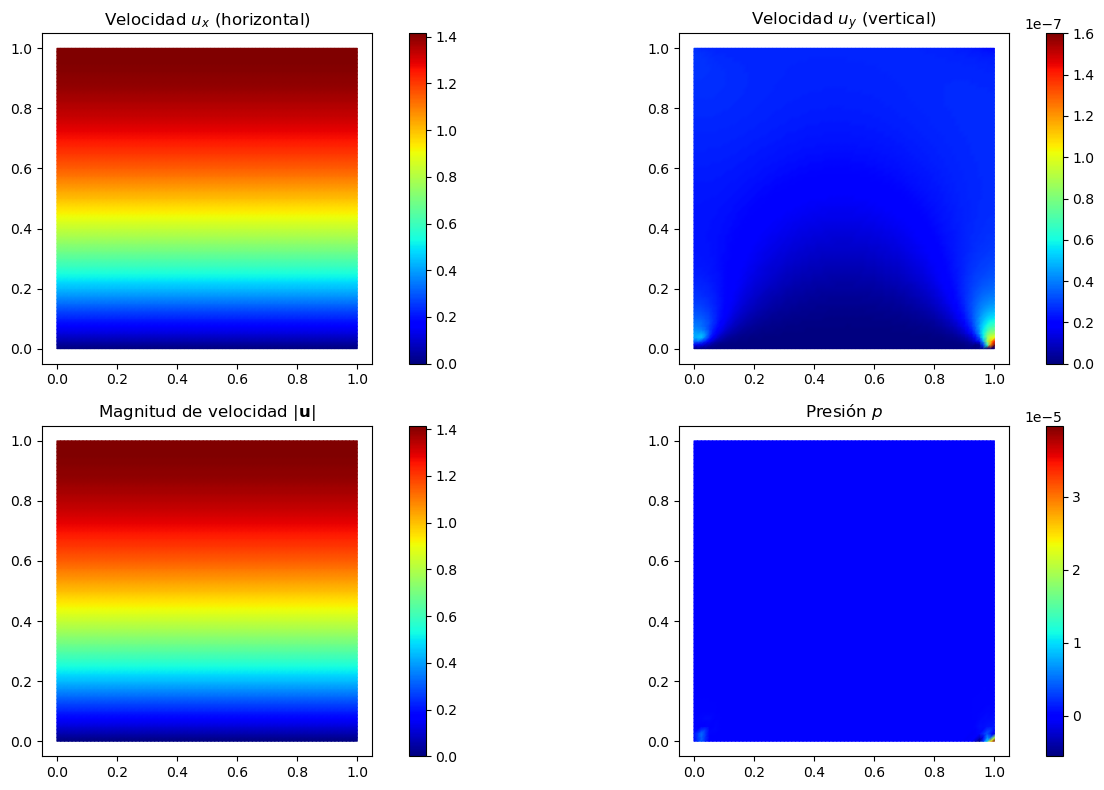

In [27]:
# Filtrar valores propios reales (parte imaginaria exactamente cero)
mask_real = np.isclose(vals.imag, 0)
vals = vals[mask_real].real
vecs = vecs[:, mask_real].real

# Ordenar autovalores
idx = np.argsort(vals)
eigenvalues = vals[idx]
eigenvectors = vecs[:, idx]

# Insertar la solución reducida en el vector global (con ceros en frontera)
u_sol = np.zeros(K.shape[0])

sol_idx = 0
u_sol[I] = eigenvectors[:, sol_idx]  # Primer modo

# Separar componentes de velocidad y presión
u_velocity = u_sol[:Nu]
p_pressure = u_sol[Nu:]
graficar_stokes(u_velocity, p_pressure, mesh, basis_p, basis_u)

In [ ]:
vals_extr1 = [2.4674, 6.2793, 15.2090, 22.2065, 26.9479, 43.1419]
tabla_eigen = pd.DataFrame({
    'Test': ['Extrapolado FEM', 'SKFEM'],
    'Valor propio 1': [vals_extr1[0], eigenvalues[0]],
    'Valor propio 2': [vals_extr1[1], eigenvalues[1]],
    'Valor propio 3': [vals_extr1[2], eigenvalues[2]],
    'Valor propio 4': [vals_extr1[3], eigenvalues[3]],
    'Valor propio 5': [vals_extr1[4], eigenvalues[4]],
    'Valor propio 6': [vals_extr1[5], eigenvalues[5]],
})
tabla_eigen

,Test,Valor propio 1,Valor propio 2,Valor propio 3,Valor propio 4,Valor propio 5,Valor propio 6
0,Extrapolado FEM,2.467400,6.279300,15.209000,22.206500,26.947900,43.14190
1,SKFEM,2.467401,6.279308,15.209042,22.206616,26.948256,43.14127
